# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
from tqdm.notebook import tqdm

In [3]:
import IPython.display as ipd

In [4]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [5]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Load models

In [7]:
mobilenet_model = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                           pooling='max', input_shape=(224, 224, 3))

In [8]:
def mobilenet_preprocessing(img):
    if img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))
    img = mobilenet_v2.preprocess_input(img)
    return img

In [9]:
models_dir = "../Images/models"
model_number = "30"
simple_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [10]:
mask = utils_2d.create_mask()
new_width = 100

def simple_preprocessing(img):
    img = img[:,:,::-1].astype('uint8')
    gray = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
    gray = simple_prep_fun(gray)
    return gray

## Load Features Functions

In [11]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [12]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_person=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"], folders = None, np_seed = 0):

    paths = []
    features = []
    if folders is None:
        folders = os.listdir(base_path)
    for folder in tqdm(folders):
        #print(folder)
        path = base_path + "/" + folder
        if os.path.isdir(path):
            filenames = os.listdir(path)
            np.random.seed(np_seed)
            random_filenames = np.random.choice(filenames,
                                                np.min([len(filenames), pics_per_person]),
                                                replace=False)
            for f in sorted(random_filenames):
                if (f[-3:] in file_formats):
                    # Memorizza percorso file
                    cur_path = path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, np.array(paths)

# Retrieval - Celebrities pictures

In [13]:
path = "celebrities_full/"

In [14]:
classes = sorted(os.listdir(path))

In [15]:
len(classes)

1580

In [16]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

There are 1580 classes.

We are going to compute features for 50 random pictures for each class.

In [17]:
pics_per_person = 50

We discard classes with less than 30 pictures:

In [18]:
classes = [cls for cls in classes if len(os.listdir(path+cls)) >= pics_per_person]

In [19]:
len(classes)

1214

In [20]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

In [21]:
# %%time
# mobilenet_X_train, paths = load_data(path, mobilenet_model, mobilenet_preprocessing,
#                                   pics_per_person=pics_per_person, folders=classes)

We save the features and paths:

In [22]:
# np.save("features/mobilenet_X_train_50ppp", mobilenet_X_train)
# np.save("features/mobilenet_paths_50ppp", paths)

In [23]:
paths = np.load("features/mobilenet_paths_50ppp.npy")
mobilenet_X_train = np.load("features/mobilenet_X_train_50ppp.npy")

## Albero di ricerca

In [24]:
mobilenet_X_train.shape

(58656, 1280)

In [25]:
%%time
tree = KDTree(mobilenet_X_train)

CPU times: user 6.42 s, sys: 116 ms, total: 6.54 s
Wall time: 6.52 s


In [26]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Example Query #1

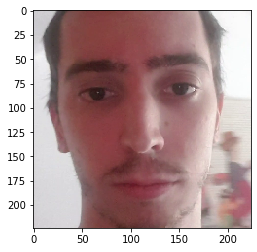

In [27]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"gian/gian_6.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

In [28]:
%time
query_features = compute_features(kimage.img_to_array(img), mobilenet_model, mobilenet_preprocessing)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


Interrogo l'albero di ricerca

In [29]:
%%time
dist, ind = tree.query(query_features.reshape(1, -1), k=10)

CPU times: user 354 ms, sys: 740 ms, total: 1.09 s
Wall time: 151 ms


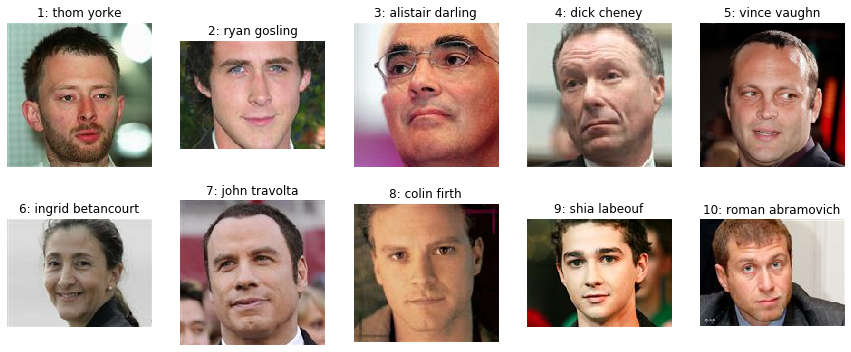

In [30]:
plot_imgs(paths, ind)

## Query #2

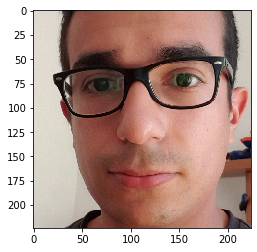

In [31]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"khaled/khaled_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

Interrogo l'albero di ricerca

In [32]:
%time
query_features = compute_features(kimage.img_to_array(img), mobilenet_model, mobilenet_preprocessing)
dist, ind = tree.query(query_features.reshape(1, -1), k=10)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


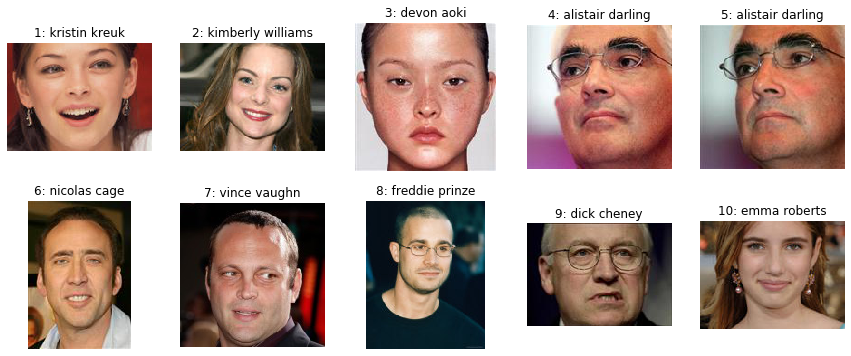

In [33]:
plot_imgs(paths, ind)

# Query all pictures for each person

We now query all pictures for:

- Alessandro,
- Alinda,
- Cami,
- Gian,
- Khaled,
- Luca,
- Mamma,
- Papi,

take the mode of the first ten retrieved celebrities, and count how many times each celebrity is considered the most similar.

In [34]:
from scipy.stats import mode

In [35]:
def query_all_pictures(cls, classes, model, preprocessing, test_dir = "../Images/test_pictures/"):
    query_pictures = [test_dir+cls+"/"+f for f in os.listdir(test_dir+cls)]
    d = {}
    for cel in classes:
        d[cel] = 0
    maxl = np.max([len(cel) for cel in classes ]) + 1
        
    tot = len(query_pictures)
    i = 0
    for file in query_pictures:
        i+=1
        img =  kimage.load_img(file, target_size=(224, 224))
        query_features = compute_features(kimage.img_to_array(img), model, preprocessing)
        dist, ind = tree.query(query_features.reshape(1, -1), k=10)
        predicted = np.array(paths)[ind[0]]
        predicted = [p.split("/")[-2] for p in predicted]
        if np.max(np.unique(predicted, return_counts=True)[1]) > 1:
            predicted = mode(predicted)[0][0]
        else:
            # otherwise we take the most similar
            predicted = predicted[0]
        d[predicted] += 1
        ipd.clear_output(wait=True)
        
        print(cls)
        print("Query #{}/{}\n".format(i, tot))
        
        print(f"{'':{maxl}s}  {'counts':},  {'percent'}")
        for j in sorted(d.keys(), key = lambda x : -d[x])[:10]:
            # print("{:14s}: {:3d}, {:>02.2f}%".format(j, d[j], d[j]/i*100))
            print(f"{j:{maxl}s}: {d[j]:6d}, {d[j]/i*100:>7.2f}%")

In [36]:
%%time
query_all_pictures("alessandro", classes, mobilenet_model, mobilenet_preprocessing)

alessandro
Query #100/100

                        counts,  percent
garcia bernal         :     15,   15.00%
chace crawford        :     10,   10.00%
marcia cross          :      6,    6.00%
vince vaughn          :      4,    4.00%
austin powers         :      3,    3.00%
diane lane            :      3,    3.00%
kimberly williams     :      3,    3.00%
noel gallagher        :      3,    3.00%
ricky gervais         :      3,    3.00%
zlatan ibrahimovic    :      3,    3.00%
CPU times: user 1min 42s, sys: 2min 44s, total: 4min 26s
Wall time: 40.9 s


In [37]:
%%time
query_all_pictures("alinda", classes, mobilenet_model, mobilenet_preprocessing)

alinda
Query #100/100

                        counts,  percent
bruce willis          :     16,   16.00%
marcia cross          :      9,    9.00%
diane lane            :      7,    7.00%
brooke burns          :      6,    6.00%
kenneth branagh       :      6,    6.00%
dmitry medvedev       :      4,    4.00%
matthew mcconaughey   :      4,    4.00%
michael rosenbaum     :      4,    4.00%
colin firth           :      3,    3.00%
ingrid betancourt     :      3,    3.00%
CPU times: user 1min 46s, sys: 2min 44s, total: 4min 30s
Wall time: 43 s


In [38]:
%%time
query_all_pictures("cami", classes, mobilenet_model, mobilenet_preprocessing)

cami
Query #100/100

                        counts,  percent
helen hunt            :     37,   37.00%
marcia cross          :     17,   17.00%
mariska hargitay      :     13,   13.00%
olga kurylenko        :     11,   11.00%
emma watson           :      6,    6.00%
maggie grace          :      4,    4.00%
ashley scott          :      2,    2.00%
kimberly williams     :      2,    2.00%
olivia wilde          :      2,    2.00%
amy smart             :      1,    1.00%
CPU times: user 1min 49s, sys: 2min 50s, total: 4min 40s
Wall time: 45.5 s


In [39]:
%%time
query_all_pictures("gian", classes, mobilenet_model, mobilenet_preprocessing)

gian
Query #100/100

                        counts,  percent
alistair darling      :     31,   31.00%
vince vaughn          :     14,   14.00%
bill murray           :     11,   11.00%
frank iero            :      6,    6.00%
andy garcia           :      5,    5.00%
ricky gervais         :      5,    5.00%
thom yorke            :      4,    4.00%
dmitry medvedev       :      3,    3.00%
jason lee             :      3,    3.00%
du bois               :      2,    2.00%
CPU times: user 1min 48s, sys: 2min 48s, total: 4min 37s
Wall time: 45.6 s


In [40]:
%%time
query_all_pictures("khaled", classes, mobilenet_model, mobilenet_preprocessing)

khaled
Query #100/100

                        counts,  percent
john travolta         :     39,   39.00%
john barrowman        :      9,    9.00%
kristin kreuk         :      9,    9.00%
kimberly williams     :      8,    8.00%
nicolas cage          :      8,    8.00%
alistair darling      :      6,    6.00%
eliot spitzer         :      5,    5.00%
robert downey         :      3,    3.00%
chace crawford        :      2,    2.00%
vince vaughn          :      2,    2.00%
CPU times: user 1min 46s, sys: 2min 44s, total: 4min 31s
Wall time: 43.2 s


In [41]:
%%time
query_all_pictures("luca", classes, mobilenet_model, mobilenet_preprocessing)

luca
Query #100/100

                        counts,  percent
orlando bloom         :     14,   14.00%
matt dillon           :     11,   11.00%
howard dean           :      8,    8.00%
sean connery          :      8,    8.00%
noel gallagher        :      7,    7.00%
ingrid betancourt     :      5,    5.00%
matthew perry         :      4,    4.00%
alistair darling      :      3,    3.00%
demi moore            :      3,    3.00%
james franco          :      3,    3.00%
CPU times: user 1min 46s, sys: 2min 42s, total: 4min 29s
Wall time: 41.5 s


In [42]:
%%time
query_all_pictures("mamma", classes, mobilenet_model, mobilenet_preprocessing)

mamma
Query #100/100

                        counts,  percent
olga kurylenko        :     18,   18.00%
gordon ramsay         :      8,    8.00%
john barrowman        :      8,    8.00%
du bois               :      6,    6.00%
kevin bacon           :      4,    4.00%
james dean            :      3,    3.00%
renee zellweger       :      3,    3.00%
ricky gervais         :      3,    3.00%
rosamund pike         :      3,    3.00%
sarah palin           :      3,    3.00%
CPU times: user 1min 48s, sys: 2min 47s, total: 4min 36s
Wall time: 44 s


In [43]:
%%time
query_all_pictures("papi", classes, mobilenet_model, mobilenet_preprocessing)

papi
Query #100/100

                        counts,  percent
john travolta         :     21,   21.00%
vince vaughn          :     21,   21.00%
kevin federline       :      6,    6.00%
macaulay culkin       :      5,    5.00%
andy garcia           :      4,    4.00%
dick cheney           :      4,    4.00%
du bois               :      3,    3.00%
wayne rooney          :      3,    3.00%
ben bernanke          :      2,    2.00%
emile hirsch          :      2,    2.00%
CPU times: user 1min 47s, sys: 2min 46s, total: 4min 34s
Wall time: 43.4 s
